In [2]:
import cv2
import numpy as np
from scipy.spatial import KDTree
import matplotlib.pyplot as plt
from typing import List, Tuple, Dict
from dataclasses import dataclass

In [ ]:


@dataclass
class Component:
    """Class to store connected component information"""
    bbox: Tuple[int, int, int, int]  # x, y, w, h
    centroid: Tuple[float, float]
    area: int

class Docstrum:
    def __init__(self, k_nearest: int = 5, angle_threshold: float = 30):
        """
        Initialize docstrum processor
        
        Args:
            k_nearest: Number of nearest neighbors to find (default 5)
            angle_threshold: Angle threshold in degrees for within-line connections
        """
        self.k = k_nearest
        self.angle_threshold = angle_threshold

    def preprocess(self, image: np.ndarray) -> np.ndarray:
        """
        Preprocess the image - noise reduction and binarization
        
        Args:
            image: Input grayscale image
            
        Returns:
            Binary image
        """
        # Apply Otsu's thresholding
        _, binary = cv2.threshold(image, 0, 255, cv2.THRESH_BINARY + cv2.THRESH_OTSU)
        
        # Apply morphological operations to remove noise
        kernel = np.ones((3,3), np.uint8)
        binary = cv2.morphologyEx(binary, cv2.MORPH_CLOSE, kernel)
        binary = cv2.morphologyEx(binary, cv2.MORPH_OPEN, kernel)
        
        return binary

    def find_connected_components(self, binary: np.ndarray) -> List[Component]:
        """
        Find connected components in binary image and filter them based on size
        
        Args:
            binary: Binary image
            
        Returns:
            List of Component objects
        """
        # Invert binary image if needed (assuming text is black)
        if np.mean(binary) > 127:
            binary = cv2.bitwise_not(binary)
            
        # Find connected components
        num_labels, labels, stats, centroids = cv2.connectedComponentsWithStats(binary)
        
        if num_labels < 2:  # 1 is background
            raise ValueError("No components found in the image")
        
        # Calculate median area to use for filtering
        areas = stats[1:, cv2.CC_STAT_AREA]  # Skip background
        median_area = np.median(areas)
        
        components = []
        # Skip background component (index 0)
        for i in range(1, num_labels):
            area = stats[i, cv2.CC_STAT_AREA]
            
            # Filter out components that are too small or too large
            if area < median_area * 0.05 or area > median_area * 20:
                continue
                
            x = stats[i, cv2.CC_STAT_LEFT]
            y = stats[i, cv2.CC_STAT_TOP]
            w = stats[i, cv2.CC_STAT_WIDTH]
            h = stats[i, cv2.CC_STAT_HEIGHT]
            
            components.append(Component(
                bbox=(x, y, w, h),
                centroid=(centroids[i][0], centroids[i][1]),
                area=area
            ))
        
        if not components:
            raise ValueError("No valid components found after filtering")
            
        print(f"Found {len(components)} valid components")
        return components

    def find_nearest_neighbors(self, components: List[Component]) -> List[List[Tuple[int, float, float]]]:
        """
        Find k nearest neighbors for each component
        
        Args:
            components: List of components
            
        Returns:
            List of lists containing (neighbor_idx, distance, angle) tuples for each component
        """
        if len(components) < self.k + 1:
            raise ValueError(f"Not enough components ({len(components)}) for k={self.k} nearest neighbors")
            
        # Extract centroids
        points = np.array([c.centroid for c in components])
        
        # Adjust k if necessary
        k = min(self.k + 1, len(components))
        print(f"Finding {k-1} nearest neighbors for each component")
        
        # Build KD-tree for efficient nearest neighbor search
        tree = KDTree(points)
        
        # Find k nearest neighbors (first one is the point itself)
        distances, indices = tree.query(points, k=k)
        
        neighbors_info = []
        for i, (component_neighbors, neighbor_distances) in enumerate(zip(indices, distances)):
            # Skip the first neighbor (point itself)
            neighbors = []
            for j, (neighbor_idx, dist) in enumerate(zip(component_neighbors[1:], neighbor_distances[1:]), 1):
                # Calculate angle between components
                dx = points[neighbor_idx][0] - points[i][0]
                dy = points[neighbor_idx][1] - points[i][1]
                angle = np.degrees(np.arctan2(dy, dx)) % 180
                
                neighbors.append((neighbor_idx, dist, angle))
            
            neighbors_info.append(neighbors)
            
        return neighbors_info

    def estimate_orientation(self, neighbors_info: List[List[Tuple[int, float, float]]]) -> float:
        """
        Estimate document orientation from neighbor angles
        
        Args:
            neighbors_info: List of neighbor information
            
        Returns:
            Estimated orientation angle in degrees
        """
        # Collect all angles
        angles = []
        for component_neighbors in neighbors_info:
            angles.extend([n[2] for n in component_neighbors])
            
        # Create histogram of angles
        hist, bins = np.histogram(angles, bins=180, range=(0, 180))
        
        # Apply smoothing to histogram
        hist = np.convolve(hist, np.ones(5)/5, mode='same')
        
        # Find peak
        orientation = bins[np.argmax(hist)]
        
        return orientation

    def find_text_lines(self, components: List[Component], 
                       neighbors_info: List[List[Tuple[int, float, float]]], 
                       orientation: float) -> List[List[int]]:
        """
        Group components into text lines
        
        Args:
            components: List of components
            neighbors_info: List of neighbor information
            orientation: Estimated text orientation
            
        Returns:
            List of text lines, where each line is a list of component indices
        """
        # Create graph of connected components
        graph = {i: [] for i in range(len(components))}
        
        for i, component_neighbors in enumerate(neighbors_info):
            for neighbor_idx, dist, angle in component_neighbors:
                # Check if angle is within threshold of orientation
                angle_diff = min((angle - orientation) % 180, (orientation - angle) % 180)
                if angle_diff < self.angle_threshold:
                    graph[i].append(neighbor_idx)
                    graph[neighbor_idx].append(i)
        
        # Find connected components in graph (text lines)
        text_lines = []
        visited = set()
        
        def dfs(node: int, current_line: List[int]):
            visited.add(node)
            current_line.append(node)
            for neighbor in graph[node]:
                if neighbor not in visited:
                    dfs(neighbor, current_line)
        
        for i in range(len(components)):
            if i not in visited:
                current_line = []
                dfs(i, current_line)
                # Sort components in line by x-coordinate for left-to-right reading
                current_line.sort(key=lambda idx: components[idx].centroid[0])
                text_lines.append(current_line)
        
        # Sort text lines by y-coordinate (top to bottom)
        text_lines.sort(key=lambda line: min(components[idx].centroid[1] for idx in line))
        
        return text_lines
        
    def find_blocks(self, components: List[Component], text_lines: List[List[int]], 
                   max_vertical_gap: float = 2.5) -> List[List[List[int]]]:
        """
        Group text lines into blocks based on vertical spacing
        
        Args:
            components: List of components
            text_lines: List of text lines
            max_vertical_gap: Maximum allowed vertical gap between lines in a block,
                            as a factor of median line spacing
            
        Returns:
            List of blocks, where each block is a list of text lines
        """
        if not text_lines:
            return []
            
        # Calculate median line spacing
        line_spacings = []
        for i in range(len(text_lines) - 1):
            current_line_bottom = max(components[idx].bbox[1] + components[idx].bbox[3] 
                                    for idx in text_lines[i])
            next_line_top = min(components[idx].bbox[1] 
                              for idx in text_lines[i + 1])
            line_spacings.append(next_line_top - current_line_bottom)
            
        if not line_spacings:
            return [text_lines]  # Single block with all lines
            
        median_spacing = np.median(line_spacings)
        
        # Group lines into blocks
        blocks = []
        current_block = [text_lines[0]]
        
        for i in range(1, len(text_lines)):
            current_line = text_lines[i]
            prev_line = text_lines[i - 1]
            
            # Calculate vertical gap between lines
            prev_line_bottom = max(components[idx].bbox[1] + components[idx].bbox[3] 
                                 for idx in prev_line)
            current_line_top = min(components[idx].bbox[1] 
                                 for idx in current_line)
            gap = current_line_top - prev_line_bottom
            
            if gap > median_spacing * max_vertical_gap:
                # Start new block
                blocks.append(current_block)
                current_block = [current_line]
            else:
                # Add to current block
                current_block.append(current_line)
        
        # Add last block
        blocks.append(current_block)
        
        return blocks

    def process(self, image: np.ndarray) -> Tuple[List[Component], List[List[int]], float]:
        """
        Main processing function
        
        Args:
            image: Input grayscale image
            
        Returns:
            Tuple containing:
            - List of components
            - List of text lines
            - Estimated orientation
        """
        # Preprocess image
        binary = self.preprocess(image)
        
        # Find connected components
        components = self.find_connected_components(binary)
        
        # Find nearest neighbors
        neighbors_info = self.find_nearest_neighbors(components)
        
        # Estimate orientation
        orientation = self.estimate_orientation(neighbors_info)
        
        # Find text lines
        text_lines = self.find_text_lines(components, neighbors_info, orientation)
        
        return components, text_lines, orientation

    def visualize_results(self, image: np.ndarray, components: List[Component], 
                         text_lines: List[List[int]], orientation: float):
        """
        Visualize the results with text lines and blocks
        
        Args:
            image: Original image
            components: List of components
            text_lines: List of text lines
            orientation: Estimated orientation
        """
        # Create RGB visualization image
        vis_image = cv2.cvtColor(image.copy(), cv2.COLOR_GRAY2RGB)
        
        # Find blocks
        blocks = self.find_blocks(components, text_lines)
        
        # Generate colors for blocks
        block_colors = np.random.randint(0, 255, (len(blocks), 3)).tolist()
        
        # Draw blocks and their components
        for block_idx, block in enumerate(blocks):
            # Get block bounding box
            block_components = [comp_idx for line in block for comp_idx in line]
            
            if not block_components:
                continue
                
            # Find block boundaries
            min_x = min(components[idx].bbox[0] for idx in block_components)
            min_y = min(components[idx].bbox[1] for idx in block_components)
            max_x = max(components[idx].bbox[0] + components[idx].bbox[2] 
                       for idx in block_components)
            max_y = max(components[idx].bbox[1] + components[idx].bbox[3] 
                       for idx in block_components)
            
            # Draw block rectangle
            color = block_colors[block_idx]
            cv2.rectangle(vis_image, (min_x-5, min_y-5), (max_x+5, max_y+5), color, 2)
            
            # Draw components within the block
            for line in block:
                for comp_idx in line:
                    x, y, w, h = components[comp_idx].bbox
                    # Draw component rectangles in a lighter shade
                    light_color = [min(c + 50, 255) for c in color]
                    cv2.rectangle(vis_image, (x, y), (x + w, y + h), light_color, 1)
        
        plt.figure(figsize=(15, 10))
        plt.imshow(vis_image)
        plt.title(f'Detected Text Blocks (Orientation: {orientation:.1f}°)')
        plt.axis('off')
        plt.show()

def main():
    # Load and process example image
    image = cv2.imread('input_2.png', cv2.IMREAD_GRAYSCALE)
    if image is None:
        raise ValueError("Could not load image")
        
    print(f"Loaded image with shape: {image.shape}")
    
    try:
        # Initialize and run docstrum
        docstrum = Docstrum(k_nearest=5, angle_threshold=30)
        components, text_lines, orientation = docstrum.process(image)
        
        print(f"Processing complete:")
        print(f"- Found {len(components)} components")
        print(f"- Grouped into {len(text_lines)} text lines")
        print(f"- Estimated orientation: {orientation:.1f} degrees")
        
        # Visualize results
        docstrum.visualize_results(image, components, text_lines, orientation)
        
    except ValueError as e:
        print(f"Error processing image: {e}")
    except Exception as e:
        print(f"Unexpected error: {e}")
        raise

if __name__ == '__main__':
    main()

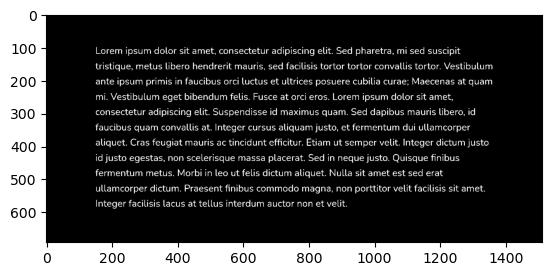

In [4]:
image = cv2.imread('input_2.png', cv2.IMREAD_GRAYSCALE)

_, binary_image = cv2.threshold(image, 0, 255, cv2.THRESH_BINARY + cv2.THRESH_OTSU)

binary_image = (binary_image == 0).astype(np.uint8)
plt.imshow(binary_image, cmap='gray')